# Introduction

<br>

<img alt="Pulsar Image" max-width=480 width=480 src="https://aasnova.org/wp-content/uploads/2015/09/fig17-e1443626962683.jpg" />

"Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted, which treat the candidate data sets as binary classification problems." This notebook attempts to use attributes given in the data set to classify signals into positive and negative classes where positive class indicates a legitimate pulsar signal.

(https://archive.ics.uci.edu/ml/datasets/HTRU2)

In [1]:
import time
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Import Dataset

In [2]:
dataRaw = []
DataFile = open("dataset/HTRU_2.arff", "r")

while True:
    the_line = DataFile.readline()
    if len(the_line) == 0:
        break
    
    if the_line[0] != '@':
        readData = the_line.split(",")
        for pos in range(len(readData)):
            if "\n" in readData[pos]:
                readData[pos] = readData[pos].replace("\n","")
        dataRaw.append(readData)

DataFile.close()

colsName = ['mean', 'stdev', 'skewness', 'kurtosis', 'dm_mean', 'dm_stdev', 'dm_skewness', 'dm_kurtosis', 'class']

df = pd.DataFrame(
    data=dataRaw,
    columns=colsName
)

df = df.apply(pd.to_numeric)
print(df.shape)
df.head(5)

(17898, 9)


,mean,stdev,skewness,kurtosis,dm_mean,dm_stdev,dm_skewness,dm_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# 2. Visualisation

In [3]:
df['class'].value_counts()

0    16259
1     1639
Name: class, dtype: int64

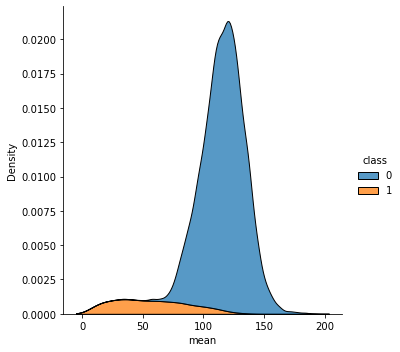

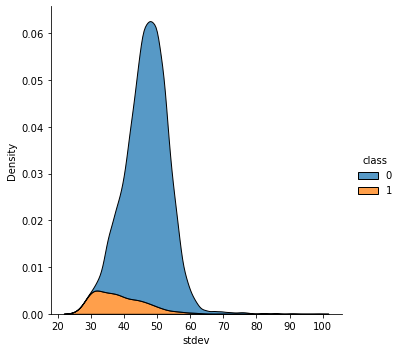

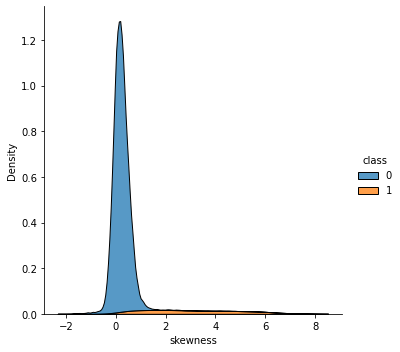

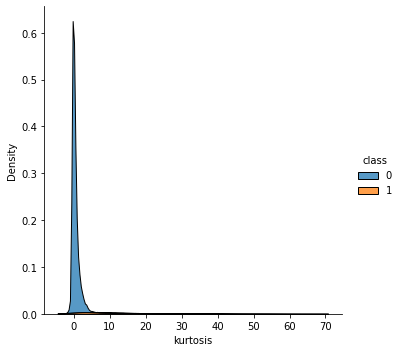

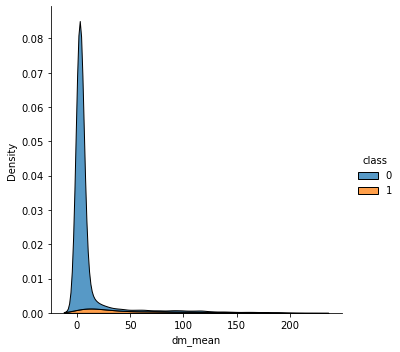

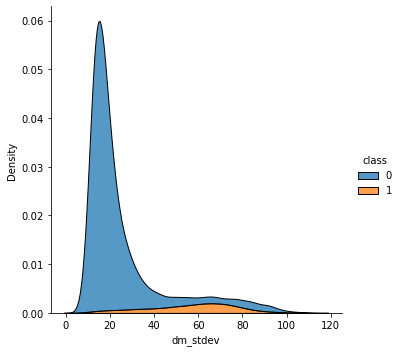

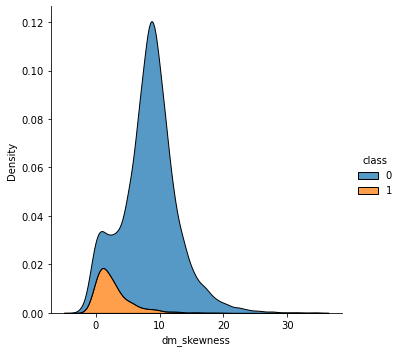

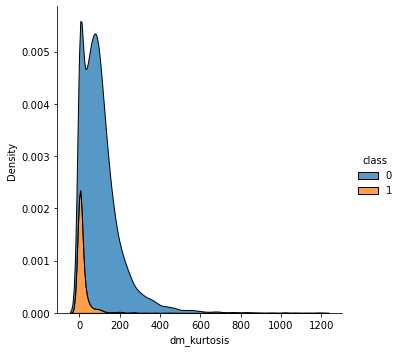

In [4]:
for i in df.columns:
    if i != 'class':
        sns.displot(df, x=i, hue="class", kind="kde", multiple="stack")

# 3. Preprocessing

In [5]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

In [6]:
X = scaled_df.drop('class', axis=1)
y = scaled_df['class']

undersample = imblearn.under_sampling.NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(X, y)

y.value_counts()

1.0    1639
0.0    1639
Name: class, dtype: int64

# 4. Modelling

In [7]:
models = Pipeline([
    ('clf', None), 
])

search = GridSearchCV(
    models, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=21), 
    return_train_score=False, 
    scoring=['accuracy'],
    refit = 'accuracy',
    param_grid={
        'clf': [MultinomialNB(), RandomForestClassifier(), SVC(), LogisticRegression(max_iter=1000)]        
})

In [8]:
start = time.time()
search.fit(X, y)
print('total fitting time:', round((time.time() - start)/60,2), 'minute(s)')

total fitting time: 0.13 minute(s)


In [9]:
print('Best model:', search.best_params_)
model_comparison = pd.DataFrame(search.cv_results_)
model_comparison

Best model: {'clf': RandomForestClassifier()}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.005863,0.006279,0.002360,0.004519,MultinomialNB(),{'clf': MultinomialNB()},0.929878,0.896341,0.881098,0.902439,0.905488,0.923780,0.893293,0.884146,0.941896,0.932722,0.909108,0.020390,4
1,0.582644,0.022555,0.016864,0.007077,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.972561,0.945122,0.948171,0.932927,0.942073,0.963415,0.957317,0.935976,0.954128,0.966361,0.951805,0.012541,1
2,0.057387,0.006265,0.006884,0.004250,SVC(),{'clf': SVC()},0.969512,0.948171,0.935976,0.926829,0.932927,0.960366,0.948171,0.917683,0.966361,0.951070,0.945707,0.016275,2
3,0.014278,0.003870,0.002360,0.004520,LogisticRegression(max_iter=1000),{'clf': LogisticRegression(max_iter=1000)},0.960366,0.926829,0.923780,0.917683,0.932927,0.945122,0.935976,0.908537,0.957187,0.944954,0.935336,0.015919,3


# 5. Evaluation

In [10]:
cv_result = pd.DataFrame()
cv_result['mean'] = model_comparison.mean_test_accuracy * 100
cv_result['std'] = model_comparison.std_test_accuracy * 100
cv_result['model'] = ['Naive Bayes', 'Random Forest', 'SVM', 'Logistic Regression']
cv_result

,mean,std,model
0,90.910812,2.039043,Naive Bayes
1,95.180503,1.254106,Random Forest
2,94.570653,1.627515,SVM
3,93.533602,1.591905,Logistic Regression


C:\Users\ibrahi15\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


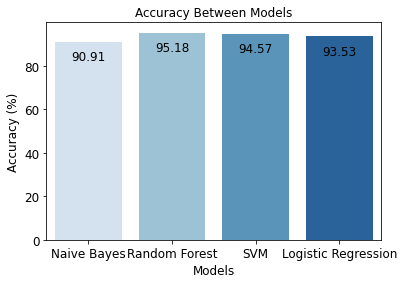

In [11]:
# rcParams['figure.figsize'] = (8,4)
ax = sns.barplot('model', 'mean', data=cv_result, capsize=.05, palette='Blues', ci=None)
ax.set_xlabel("Models",fontsize=12)
ax.set_ylabel("Accuracy (%)",fontsize=12)
ax.tick_params(labelsize=12)
ax.axes.set_title("Accuracy Between Models", fontsize=12)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=12, color='black', xytext=(0, -15),
    textcoords='offset points')

Accuracy:  1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       492
         1.0       1.00      1.00      1.00       492

    accuracy                           1.00       984
   macro avg       1.00      1.00      1.00       984
weighted avg       1.00      1.00      1.00       984



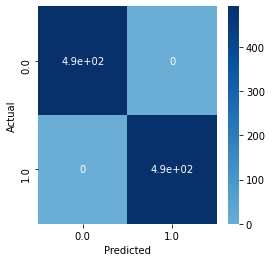

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=11, 
    stratify=y
)

def confusion_matrix_heatmap(cm, index, dim):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (dim, dim)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="Blues", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

prediction = search.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
confusion_matrix_heatmap(confusion_matrix(y_test, prediction), search.classes_, 4)